In [1]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
import gensim.models as genmodels
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

c:\Users\lesmo\AppData\Local\Programs\Python\Python39\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df = pickle.load(open("../data/merged_hotel_data.pkl", "rb"))
df=df.replace(r'^\s*$', np.nan, regex=True)
print(df.shape)
#df.head()


(76536, 31)


In [4]:
df.columns

Index(['hotel_name_', 'stars', 'location', 'review_rating', 'description',
       'main_facilities', 'total_reviews', 'sub_ratings',
       'sub_ratings_categories', 'sub_ratings_dict', 'hotel_surroundings',
       'hotel_surroundings_distance', 'surroundings_dict', 'room_type_x',
       'price_list', 'cheapest_price', 'facilities_groups', 'all_facilities',
       'link', 'room_price_dict', 'name', 'room_type_y', 'nights_stayed',
       'month_stayed', 'occupant_type', 'from_country', 'review_score',
       'date_reviewed', 'short_review', 'positive_review', 'negative_review'],
      dtype='object')

In [5]:
default_comments=["Exceptional", "Very Good", "Wonderful", "Good", "Pleasant","Fair", "Disappointing","Bad", "Poor",
                 "Excellent", "Very Poor", "Okay", "Great","Very Good","Ok"]

pattern = '|'.join(default_comments)
df_reviews_sr=df[["negative_review"]].dropna()
df_reviews_sr=df_reviews_sr[~df_reviews_sr.negative_review.str.contains(pattern)]
df_reviews_sr

,negative_review
1,room is quite old already.
2,There was cockroach and the shower valve does ...
3,Wifi in the room is poor :(
5,"The room looks old, the bathrooms drainage is ..."
6,Bed was not comfortable and there were rowdy a...
...,...
76432,When I checked in and through my stay I was fi...
76434,they don’t follow what it showed while you boo...
76435,bathroom glass door needs to be replaced
76436,Washroom is dirty


In [6]:
# Convert to list 
data = df_reviews_sr.negative_review.values.tolist()  
# # Remove Emails 
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
# # Remove new line characters 
# data = [re.sub('\s+', ' ', sent) for sent in data]  
# # Remove distracting single quotes 
# data = [re.sub("\'", "", sent) for sent in data]
# #Remove \n
# data = [re.sub("\n", "", sent) for sent in data]
# data = [re.sub("(Image courtesy: )", "", sent) for sent in data]
# #Remove links
# data = [re.sub(r'http\S+', '', sent) for sent in data]
display(len(data))
print(data[8])

24934

aportable


### Tokenization

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:9]) 

[['room', 'is', 'quite', 'old', 'already'], ['there', 'was', 'cockroach', 'and', 'the', 'shower', 'valve', 'does', 'not', 'closed', 'fully'], ['wifi', 'in', 'the', 'room', 'is', 'poor'], ['the', 'room', 'looks', 'old', 'the', 'bathrooms', 'drainage', 'is', 'not', 'that', 'good'], ['bed', 'was', 'not', 'comfortable', 'and', 'there', 'were', 'rowdy', 'and', 'loud', 'guests'], ['no', 'phone', 'in', 'rooms'], ['better', 'mentioned', 'if', 'the', 'placed', 'is', 'accredited', 'for', 'quarantine', 'or', 'not', 'to', 'avoid', 'confusion', 'but', 'anyhow', 'it', 'is', 'enjoyable', 'stay', 'in', 'your', 'nice', 'hotel', 'thank', 'you'], ['needs', 'to', 'educate', 'the', 'staff', 'on', 'how', 'to', 'deal', 'with', 'customers', 'no', 'available', 'towels'], ['aportable']]


### Building the bigram and trigram Models

In [8]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)


In [9]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[8]]])

['aportable']


### Define function for stopwords, bigrams, trigrams and lemmatization

In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)


In [12]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

#nlp = spacy.load('en_core_web_lg')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_bi = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
data_lemmatized_tri = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])
print(data_lemmatized_bi[-1])

c:\Users\lesmo\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
len(data_lemmatized_bi)

24934

In [ ]:
id2word_bi = corpora.Dictionary(data_lemmatized_bi)  
id2word_tri = corpora.Dictionary(data_lemmatized_tri)  

In [ ]:
texts_bi = data_lemmatized_bi
texts_tri = data_lemmatized_tri

In [ ]:
# Term Document Frequency 
corpus_bi = [id2word_bi.doc2bow(text) for text in texts_bi]  
corpus_tri = [id2word_tri.doc2bow(text) for text in texts_tri]  

In [ ]:
# View 
print(corpus_bi[:8])

[[(0, 1)], [(1, 1), (2, 1), (3, 1)], [(0, 1)], [(0, 1), (4, 1), (5, 1)], [(6, 1), (7, 1)], [(0, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [ ]:
[[(id2word_bi[id], freq) for id, freq in cp] for cp in corpus_bi[:1]]
[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri[:1]]

[[('room', 1)]]

<AxesSubplot:ylabel='word'>

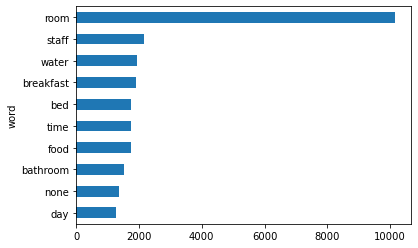

In [ ]:
bow=[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri]
flat_list = [item for sublist in bow for item in sublist]


no_value_words=["stay","good","hotel","place","nice","great"]

df_bow = pd.DataFrame(flat_list, columns = ['word', 'count'])
df_bow=df_bow[~df_bow.word.str.contains('|'.join(no_value_words))] 
df_bow.groupby("word")["count"].sum().sort_values(ascending=True).tail(10).plot.barh()

### Noun Chunks

In [ ]:
data2 = data.copy()

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')

chunks = []
for i in data2:
    doc = nlp(i)

    for chunk in doc.noun_chunks:
        out = {}
        root = chunk.root
        out[root.pos_] = root
        for tok in chunk:
            if tok != root:
                out[tok.pos_] = tok
        chunks.append(out)

In [ ]:
chunks

[{'NOUN': room},
 {'NOUN': cockroach},
 {'NOUN': shower, 'DET': the},
 {'NOUN': Wifi},
 {'NOUN': room, 'DET': the},
 {'NOUN': room, 'DET': The},
 {'NOUN': bathrooms, 'DET': the},
 {'NOUN': Bed},
 {'NOUN': guests, 'ADJ': loud, 'CCONJ': and},
 {'NOUN': phone, 'DET': no},
 {'NOUN': rooms},
 {'NOUN': quarantine},
 {'NOUN': confusion},
 {'PRON': it},
 {'NOUN': stay, 'DET': a, 'ADJ': enjoyable},
 {'NOUN': hotel, 'PRON': your, 'ADJ': nice},
 {'PRON': you},
 {'NOUN': staff, 'DET': the},
 {'NOUN': customers},
 {'NOUN': towels, 'DET': no, 'ADJ': available},
 {'NOUN': level, 'DET': the},
 {'NOUN': cleaning},
 {'NOUN': bathroom, 'DET': the},
 {'NOUN': mould},
 {'PROPN': bnb, 'DET': this, 'NOUN': air, 'CCONJ': or},
 {'NOUN': items, 'DET': all, 'PRON': their},
 {'NOUN': totality, 'DET': The},
 {'NOUN': facilities, 'DET': the},
 {'NOUN': building, 'DET': the},
 {'NOUN': Beds},
 {'NOUN': Curtains},
 {'PRON': it},
 {'PROPN': bnb, 'DET': a, 'NOUN': air, 'CCONJ': or},
 {'NOUN': internet, 'DET': The},
 {'

In [ ]:
df_chunk = pd.DataFrame.from_dict(chunks)

In [ ]:
df_chunk['NOUN'] = df_chunk['NOUN'].astype(str)
df_chunk['ADJ'] = df_chunk['ADJ'].astype(str)

In [ ]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return(lemmatizer.lemmatize(text))

df_chunk['NOUN_lemma'] = df_chunk.NOUN.apply(lemmatize_text)
df_chunk['ADJ_lemma'] = df_chunk.ADJ.apply(lemmatize_text)

In [ ]:
def lower_text(text):
    return(text.lower())

df_chunk['NOUN_lemma'] = df_chunk.NOUN.apply(lower_text)
df_chunk['ADJ_lemma'] = df_chunk.ADJ.apply(lower_text)

In [ ]:
df_chunk['NOUN_lemma'] = df_chunk['NOUN_lemma'].astype(str)
df_chunk['ADJ_lemma'] = df_chunk['ADJ_lemma'].astype(str)


In [ ]:
df_chunk

,NOUN,DET,ADJ,CCONJ,PRON,PROPN,SPACE,PUNCT,ADV,SYM,NUM,PART,VERB,ADP,AUX,INTJ,X,SCONJ,NOUN_lemma,ADJ_lemma
0,room,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,room,nan
1,cockroach,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cockroach,nan
2,shower,the,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,shower,nan
3,Wifi,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wifi,nan
4,room,the,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,room,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151750,glass,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,glass,nan
151751,Washroom,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washroom,nan
151752,cleanliness,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cleanliness,nan
151753,pest,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pest,nan


# TOP ADJECTIVES DESCRIBING TOP NOUNS

STAFF

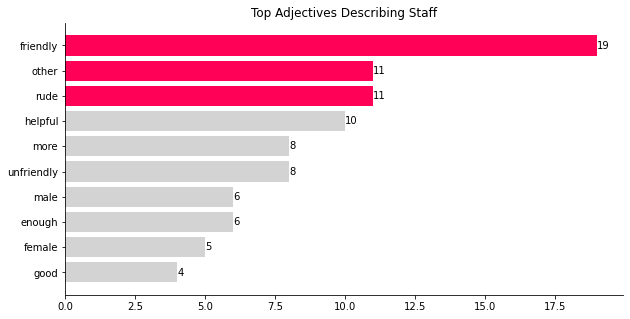

In [ ]:
staff =  df_chunk[(df_chunk['NOUN_lemma'] == 'staff') & (df_chunk['ADJ_lemma'] != 'nan')]
staff = staff[['NOUN_lemma','ADJ_lemma']]


staff_adj = pd.DataFrame({'trans_count': staff['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(staff_adj.index, staff_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Staff')
ax.bar_label(hbar)
plt.show()

ROOM

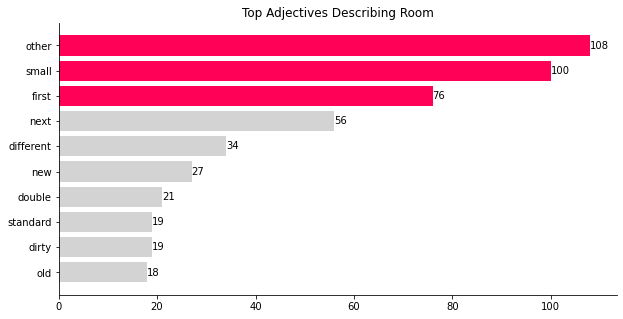

In [36]:
room =  df_chunk[(df_chunk['NOUN_lemma'] == 'room') & (df_chunk['ADJ_lemma'] != "nan")]
room = room[['NOUN_lemma','ADJ_lemma']]


room_adj = pd.DataFrame({'trans_count': room['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(room_adj.index, room_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Room')
ax.bar_label(hbar)
plt.show()

WATER

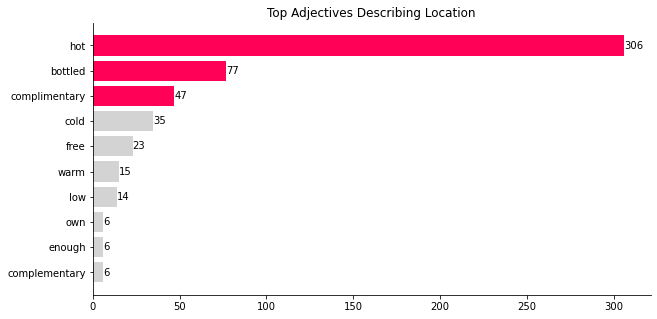

In [37]:
loct =  df_chunk[(df_chunk['NOUN_lemma'] == 'water') & (df_chunk['ADJ_lemma'] != "nan")]
loct = loct[['NOUN_lemma','ADJ_lemma']]


loct_adj = pd.DataFrame({'trans_count': loct['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(loct_adj.index, loct_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Location')
ax.bar_label(hbar)
plt.show()

BREAKFAST

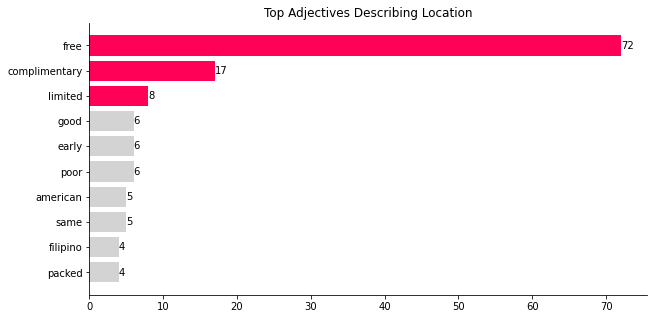

In [38]:
mon =  df_chunk[(df_chunk['NOUN_lemma'] == 'breakfast') & (df_chunk['ADJ_lemma'] != "nan")]
mon = mon[['NOUN_lemma','ADJ_lemma']]


mon_adj = pd.DataFrame({'trans_count': mon['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(mon_adj.index, mon_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Location')
ax.bar_label(hbar)
plt.show()

BED

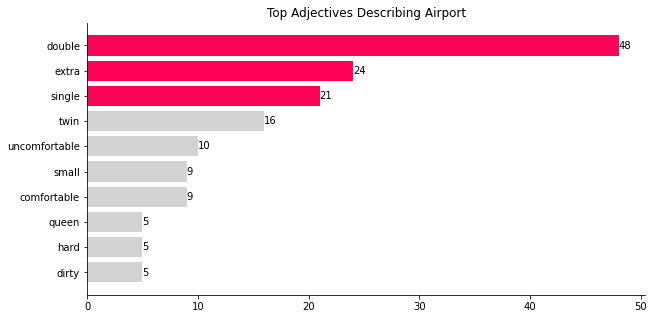

In [39]:
apt =  df_chunk[(df_chunk['NOUN_lemma'] == 'bed') & (df_chunk['ADJ_lemma'] != "nan")]
apt = apt[['NOUN_lemma','ADJ_lemma']]


apt_adj = pd.DataFrame({'trans_count': apt['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(apt_adj.index, apt_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Airport')
ax.bar_label(hbar)
plt.show()